# Assignment 2
In this assignment, I am predicting the price of small to mid-size apartments hosting 2-6 guests in Austin, TX, USA so that a fictional company can price their new apartments before putting them on the market.
I start off with the exploratory data analysis and data work, then move on to creating my predictive models and analyzing their effectiveness using RMSE. I then use the best model to predict apartment prices based on the number of accommodates. It should be noted too that due to some difficulties with dmatrices and y.ravel() when trying to do Random Forest, I ended up using the same predictor variables for all models rather than having the Dmatrix create more variables. I liked this method because it better allowed me to analyze the differences and effectiveness between each predictive model.
- Model 1: Linear Regression with OLS
- Model 2: Linear Regression with LASSO
- Model 3: CART (Regression Tree)
- Model 4: Random Forest

### Importing Beginning Libraries

In [1]:
import pandas as pd
import numpy as np
import math
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from plotnine import *
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer
from statsmodels.tools.eval_measures import mse,rmse
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import *
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from patsy import dmatrices
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.inspection import partial_dependence
import warnings
warnings.filterwarnings('ignore')

### Reading Data & Exploratory Data Analysis

In [2]:
data = pd.read_csv('austinairbnblistings.csv')

In [3]:
data.head(3)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,5456,Guesthouse in Austin · ★4.84 · 1 bedroom · 2 b...,8028,Sylvia,NaN,78702,30.26057,-97.73441,Entire home/apt,101.0,2,668,2023-11-20,3.71,1,330,47,NaN
1,5769,Home in Austin · ★4.91 · 1 bedroom · 1 bed · 1...,8186,Elizabeth,NaN,78729,30.45697,-97.78422,Private room,NaN,1,294,2023-12-07,1.76,1,0,20,NaN
2,218402,Home in Austin · ★4.74 · 1 bedroom · 1 bed · 1...,1129520,Paulette,NaN,78754,30.36145,-97.64397,Private room,30.0,28,29,2023-09-24,0.20,1,252,2,NaN


In [4]:
data.shape
#15,419 observations

(15419, 18)

In [5]:
data = data.loc[data['room_type'] == 'Entire home/apt']

In [6]:
in_depth_data = pd.read_csv('indepthaustinairbnb.csv')

In [7]:
in_depth_data.head(3)

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,5456,https://www.airbnb.com/rooms/5456,20231215200307,2023-12-16,city scrape,Guesthouse in Austin · ★4.84 · 1 bedroom · 2 b...,NaN,My neighborhood is ideally located if you want...,https://a0.muscache.com/pictures/14084884/b5a3...,8028,...,4.83,4.73,4.79,NaN,f,1,1,0,0,3.71
1,5769,https://www.airbnb.com/rooms/5769,20231215200307,2023-12-16,previous scrape,Home in Austin · ★4.91 · 1 bedroom · 1 bed · 1...,NaN,Quiet neighborhood with lots of trees and good...,https://a0.muscache.com/pictures/23822033/ac94...,8186,...,4.94,4.76,4.92,NaN,f,1,0,1,0,1.76
2,6413,https://www.airbnb.com/rooms/6413,20231215200307,2023-12-16,previous scrape,Guesthouse in Austin · ★4.97 · Studio · 1 bed ...,NaN,Travis Heights is one of the oldest neighborho...,https://a0.muscache.com/pictures/miso/Hosting-...,13879,...,4.98,4.87,4.93,NaN,f,1,1,0,0,0.70


In [8]:
in_depth_data = in_depth_data.loc[(in_depth_data['accommodates'] >=2) & (in_depth_data['accommodates'] <=6) ]

In [9]:
in_depth_data.accommodates.value_counts()

accommodates
2    3964
4    3340
6    2293
3    1047
5     837
Name: count, dtype: int64

In [10]:
#created new df airbnb (combines both previous data frames)
airbnb = pd.merge(data, in_depth_data, on = 'id')
#9,348 observations

In [11]:
#change name of column price_x to price
airbnb.rename(columns = {'price_x':'price'}, inplace = True)

In [12]:
#trying to see if I should filter out for price
airbnb.price.describe()

count     7522.000000
mean       231.591465
std        757.418606
min          1.000000
25%         92.000000
50%        127.000000
75%        194.000000
max      10000.000000
Name: price, dtype: float64

In [13]:
#Deciding to use only observations where prices are below $250 (arbitrary number I chose simply because it is above
#$194, which is the price under which 75% of the observations sit)
print(f"observations with prices below $250: {airbnb[airbnb['price'] < 250].shape[0]} observations")
print(f"observations with prices above $250: {airbnb[airbnb['price'] > 250].shape[0]} observations")

observations with prices below $250: 6329 observations
observations with prices above $250: 1107 observations


In [14]:
airbnb = airbnb[airbnb['price'] < 250]

In [15]:
airbnb.head(3)
#now 6,329 observations

,id,name_x,host_id_x,host_name_x,neighbourhood_group,neighbourhood_x,latitude_x,longitude_x,room_type_x,price,...,review_scores_communication,review_scores_location,review_scores_value,license_y,instant_bookable,calculated_host_listings_count_y,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month_y
0,5456,Guesthouse in Austin · ★4.84 · 1 bedroom · 2 b...,8028,Sylvia,NaN,78702,30.26057,-97.73441,Entire home/apt,101.0,...,4.83,4.73,4.79,NaN,f,1,1,0,0,3.71
2,6448,Guesthouse in Austin · ★4.97 · 1 bedroom · 2 b...,14156,Amy,NaN,78704,30.26034,-97.76487,Entire home/apt,159.0,...,4.97,4.97,4.89,NaN,t,1,1,0,0,2.09
4,8502,Guest suite in Austin · ★4.56 · 1 bedroom · 1 ...,25298,Karen,NaN,78741,30.23466,-97.73682,Entire home/apt,48.0,...,4.87,4.67,4.60,NaN,f,1,1,0,0,0.30


**Plan of Action:**
- outcome variable (y): Price
- predictor variables (x): accommodates, bathrooms, beds, review_scores_rating, property_type, availability_365_x, number_of_reviews, host_is_superhost, minimum_nights_y, maximum_nights
- was going to have interactions (ex. bathrooms*beds, maximum_nights*minimum_nights, availability*number_of_reviews), but plotted using ggplot and the variables didn't seem to have much correlation:

ggplot(airbnb, aes(x = 'availability_365_x', y = 'number_of_reviews_x')) + geom_point()

In [16]:
#turned bathrooms observations into floats 
airbnb['bathrooms'] = airbnb['bathrooms_text'].apply(lambda x: float(x.split()[0]) if x.split()[0].replace('.', '').isdigit() else None)

In [17]:
#turned observations into booleans (dummy)
airbnb['host_is_superhost'] = airbnb['host_is_superhost'].apply(lambda x: 1 if x == 't' else 0)

In [18]:
#DATA WORK/CLEANING VARIABLES
#must drop any null values in outcome variable (price)
airbnb.price.isnull().sum()
airbnb.dropna(subset = ['price'], inplace = True)

#bathroom observations already turned into floats. now dropping null bathrooms (only 3)
airbnb.bathrooms.isnull().sum()
airbnb.dropna(subset = ['bathrooms'], inplace = True)

#beds. dropping null beds (only 43)
airbnb.beds.isnull().sum()
airbnb.dropna(subset = ['beds'], inplace = True)

#review_scores_rating. over 1000 null values. will impute with median as distribution looks far 
#from normal (used ggplot to plot distribution). will also create flagged variable for missing review_scores_rating
#and flag variable for imputed review_scores_rating
airbnb.review_scores_rating.isnull().sum()
airbnb['missing_review_scores_flag'] = airbnb.review_scores_rating.isnull().astype(int)
airbnb['review_scores_imputed_flag'] = airbnb.review_scores_rating.isnull().astype(int)
airbnb.fillna({'review_scores_rating': airbnb['review_scores_rating'].median()}, inplace=True)

#property type. creating dummy variables (main property types: entire home, entire rental unit, entire condo, 
#entire guesthouse, entire guest suite, entire townhouse, others)
airbnb.property_type.value_counts()
airbnb['entire_home'] = (airbnb['property_type'] == 'Entire home').astype(int)
airbnb['entire_rental_unit'] = (airbnb['property_type'] == 'Entire rental unit').astype(int)
airbnb['entire_condo'] = (airbnb['property_type'] == 'Entire condo').astype(int)
airbnb['entire_guesthouse'] = (airbnb['property_type'] == 'Entire guesthouse').astype(int)
airbnb['entire_guest_suite'] = (airbnb['property_type'] == 'Entire guest suite').astype(int)
airbnb['entire_townhouse'] = (airbnb['property_type'] == 'Entire townhouse').astype(int)
property_types_exclude = ['Entire home', 'Entire rental unit', 'Entire condo', 'Entire guesthouse', 'Entire guest suite', 'Entire townhouse']
airbnb['entire_other_property_type'] = (~airbnb['property_type'].isin(property_types_exclude)).astype(int)

#availability_365_x has no null values and is int. no data work needed
airbnb.availability_365_x.isnull().sum()

#number_of_reviews_x has no null values and is int. no data work needed
airbnb.number_of_reviews_x.isnull().sum()

#host_is_superhost. already dummy variable. no data work needed
airbnb.host_is_superhost

#minimum_nights_y has no null values and is int. no data work needed
airbnb.minimum_nights_y.isnull().sum()

#maximum_nights has no null values and is int. no data work needed
airbnb.maximum_nights.isnull().sum()

#accommodates has no null values and is int. no data work needed
airbnb.accommodates.isnull().sum()

0

## Model 1: Linear Regression with OLS

In [19]:
#list of my predictor variables
selected_features = ['accommodates', 'bathrooms', 'beds', 'review_scores_rating', 'entire_home', 'entire_rental_unit', 'entire_condo',
    'entire_guesthouse' , 'entire_guest_suite' , 'entire_townhouse' , 'availability_365_x' , 'number_of_reviews_x' ,
    'host_is_superhost' , 'minimum_nights_y' , 'maximum_nights']
#entire_other_property_type is the reference category for all the other 'entire' property types listed
#not being a superhost is the refererence category for host_is_superhost

In [20]:
#used structure of code from ch-16 of the Bekes book/Jpynb to create Linear regression model with OLS

#creating training, test (workout) and holdout sets
data_train, data_holdout = train_test_split(airbnb, train_size=0.7, random_state=42)
data_train.shape, data_holdout.shape

y, X = dmatrices("price ~ " + " + ".join(selected_features), data_train)

#creating OLS model by fitting model to training set
ols_model = LinearRegression().fit(X,y)

#fitting model to test set (prediction)
y_hat = ols_model.predict(X)

#get the RMSE for the OLS model
ols_rmse = mean_squared_error(y,y_hat,squared=False)
print(f' OLS RMSE: {ols_rmse}')

#see coefficients for each variables
ols_model_coeffs_df = pd.DataFrame(
    ols_model.coef_.tolist()[0],
    index=X.design_info.column_names,
    columns=["ols_coefficient"],
).assign(ols_coefficient=lambda x: x.ols_coefficient.round(3))

ols_model_coeffs_df

 OLS RMSE: 43.16861864628394


,ols_coefficient
Intercept,0.000
accommodates,2.187
bathrooms,15.390
beds,3.413
review_scores_rating,12.727
entire_home,3.579
entire_rental_unit,-24.882
entire_condo,5.417
entire_guesthouse,-4.068
entire_guest_suite,-15.774


## Model 2: Linear regression using LASSO (fitting variables closer to zero)

In [21]:
X = airbnb[selected_features]
y = airbnb['price']

#training/test sets for X variables and y variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#standardizing the features for LASSO
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#LASSO regression model
lasso_model = Lasso(alpha=0.1) 

#fitting LASSO model on training set
lasso_model.fit(X_train_scaled, y_train)

#prediction on test set
y_pred = lasso_model.predict(X_test_scaled)

#calculating RMSE
lasso1_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", lasso1_rmse)

#coefficients of model
coefficients = pd.Series(lasso_model.coef_, index=X.columns)
print("LASSO Coefficients:")
print(coefficients)

RMSE: 43.45491561415661
LASSO Coefficients:
accommodates             3.149142
bathrooms                8.091446
beds                     3.035563
review_scores_rating     3.853126
entire_home              1.823942
entire_rental_unit     -11.277661
entire_condo             1.818213
entire_guesthouse       -1.003245
entire_guest_suite      -2.722513
entire_townhouse        -0.774427
availability_365_x      -1.928568
number_of_reviews_x     -3.857168
host_is_superhost       -0.952304
minimum_nights_y        -2.877424
maximum_nights           0.221055
dtype: float64


## Model 3: CART model (Regression Tree)

In [22]:
#again declaring y variable and X as the training set
y, X = dmatrices("price ~ " + " + ".join(selected_features), data_train)

In [23]:
#creating cart model 
cart_model = DecisionTreeRegressor(random_state=20240131)

In [24]:
#potential ccp alpha parameters
path = cart_model.cost_complexity_pruning_path(X, y.ravel())
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [25]:
ccp_alphas
ccp_alphas.shape

(3419,)

In [26]:
#trying to select best complexity parameter alpha

cart_model_cv = RandomizedSearchCV(
    cart_model,
    {"ccp_alpha":ccp_alphas},
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)
#create 50 fits
cart_model_cv.fit(X,y.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END .ccp_alpha=0.0024225906578838113;, score=-52.002 total time=   0.0s
[CV 2/5] END .ccp_alpha=0.0024225906578838113;, score=-54.576 total time=   0.0s
[CV 3/5] END .ccp_alpha=0.0024225906578838113;, score=-54.886 total time=   0.0s
[CV 4/5] END .ccp_alpha=0.0024225906578838113;, score=-54.690 total time=   0.0s
[CV 5/5] END .ccp_alpha=0.0024225906578838113;, score=-55.105 total time=   0.0s
[CV 1/5] END ..ccp_alpha=0.048451813157693584;, score=-51.939 total time=   0.1s
[CV 2/5] END ..ccp_alpha=0.048451813157693584;, score=-54.642 total time=   0.1s
[CV 3/5] END ..ccp_alpha=0.048451813157693584;, score=-54.603 total time=   0.1s
[CV 4/5] END ..ccp_alpha=0.048451813157693584;, score=-54.599 total time=   0.1s
[CV 5/5] END ..ccp_alpha=0.048451813157693584;, score=-54.865 total time=   0.1s
[CV 1/5] END ...ccp_alpha=0.46443334090392296;, score=-50.728 total time=   0.1s
[CV 2/5] END ...ccp_alpha=0.46443334090392296;, 

RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=20240131),
                   param_distributions={'ccp_alpha': array([0.00000000e+00, 1.89264895e-05, 7.57059581e-05, ...,
       5.18374158e+01, 1.97972215e+02, 2.16336734e+02])},
                   scoring='neg_root_mean_squared_error', verbose=3)

In [27]:
cart_rmse = pd.DataFrame(cart_model_cv.cv_results_).loc[
    lambda x: x.param_ccp_alpha == cart_model_cv.best_estimator_.ccp_alpha
].mean_test_score.values[0] * -1
print(f'CART RMSE: {cart_rmse}')

CART RMSE: 44.67984733957188


## Model 4: Random Forest Model

In [28]:
#For the random forest model, I tried using the Dmatrix where it chose the variables for you (created new features
#based on categorical variables, but the y.ravel() gave me errors multiple times where the shape was (0,) and I
#couldn't figure out why)- so I decided to go with the original predictor variables instead

In [29]:
#again declaring y variable and X as the training set
y, X = dmatrices("price ~ " + " + ".join(selected_features), data_train)

In [30]:
print('The theoretical recommended number of variables: {:.2f}.'.format(math.sqrt(len(X.design_info.column_names))))

The theoretical recommended number of variables: 4.00.


In [31]:
rfr = RandomForestRegressor(random_state = 20240131)

In [32]:
#setting levels of max features and min. sample leafs to have in terminal nodes
tune_grid = {"max_features": [6, 8, 10, 12], "min_samples_leaf": [5, 10, 15]}

In [33]:
#cross valdiation
rf_random = GridSearchCV(
    rfr,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

In [34]:
%%time
#takes a while (creating 6000 trees!!)
rf_model = rf_random.fit(X, y.ravel())

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END max_features=6, min_samples_leaf=5;, score=-38.206 total time=   0.9s
[CV 2/5] END max_features=6, min_samples_leaf=5;, score=-39.089 total time=   0.6s
[CV 3/5] END max_features=6, min_samples_leaf=5;, score=-38.563 total time=   0.6s
[CV 4/5] END max_features=6, min_samples_leaf=5;, score=-38.759 total time=   0.6s
[CV 5/5] END max_features=6, min_samples_leaf=5;, score=-38.669 total time=   0.6s
[CV 1/5] END max_features=6, min_samples_leaf=10;, score=-38.599 total time=   0.4s
[CV 2/5] END max_features=6, min_samples_leaf=10;, score=-39.311 total time=   0.5s
[CV 3/5] END max_features=6, min_samples_leaf=10;, score=-39.019 total time=   0.5s
[CV 4/5] END max_features=6, min_samples_leaf=10;, score=-39.355 total time=   0.5s
[CV 5/5] END max_features=6, min_samples_leaf=10;, score=-39.170 total time=   0.5s
[CV 1/5] END max_features=6, min_samples_leaf=15;, score=-38.990 total time=   0.5s
[CV 2/5] END max_fea

In [35]:
#df to see best models and RMSE
df_rf_model_cv_results = pd.DataFrame(rf_model.cv_results_)[[
    'param_max_features', 'param_min_samples_leaf', 'mean_test_score']]

In [36]:
#change names of columns
df_rf_model_cv_results.columns = ['max features', 'min node size', 'RMSE']

In [37]:
df_rf_model_cv_results
#would just take the abs value of these RMSE scores

,max features,min node size,RMSE
0,6,5,-38.656952
1,6,10,-39.090961
2,6,15,-39.349974
3,8,5,-38.647105
4,8,10,-38.994988
5,8,15,-39.288058
6,10,5,-38.687004
7,10,10,-39.012756
8,10,15,-39.278060
9,12,5,-38.706706


In [38]:
#df showing max features by min node size
df_rf_model_cv_results.pivot(
    index = 'max features', 
    columns = 'min node size', 
    values = 'RMSE').round(2)*-1

min node size,5,10,15
max features,,,
6,38.66,39.09,39.35
8,38.65,38.99,39.29
10,38.69,39.01,39.28
12,38.71,39.06,39.31


In [39]:
#best random forest score
rf_model.best_score_

-38.64710463696116

In [40]:
#best random forest parameters
rf_model.best_params_

{'max_features': 8, 'min_samples_leaf': 5}

In [41]:
#importances of each variables
pd.DataFrame(
    rf_model.best_estimator_.feature_importances_, 
    X.design_info.column_names).sort_values(by = 0, ascending = False).rename(columns = {0: 'Importance'})

,Importance
availability_365_x,0.149221
number_of_reviews_x,0.126262
entire_rental_unit,0.111102
bathrooms,0.109609
review_scores_rating,0.099900
minimum_nights_y,0.097164
maximum_nights,0.082582
accommodates,0.075405
beds,0.058037
entire_home,0.047932


In [42]:
#seeing important and cumulative importance of each predictor variable
df_var_imp = pd.DataFrame(
    rf_model.best_estimator_.feature_importances_, 
    X.design_info.column_names)\
    .reset_index()\
    .rename({"index": "variable", 0: "imp"}, axis=1)\
    .sort_values(by=["imp"], ascending=False)\
    .reset_index(drop = True)

df_var_imp['cumulative_imp'] = df_var_imp['imp'].cumsum()

In [43]:
df_var_imp.style.format({
    'imp': lambda x: f'{x:,.1%}',
    'cumulative_imp': lambda x: f'{x:,.1%}'})
#availability in the next year is the most important predictor variable

,variable,imp,cumulative_imp
0,availability_365_x,14.9%,14.9%
1,number_of_reviews_x,12.6%,27.5%
2,entire_rental_unit,11.1%,38.7%
3,bathrooms,11.0%,49.6%
4,review_scores_rating,10.0%,59.6%
5,minimum_nights_y,9.7%,69.3%
6,maximum_nights,8.3%,77.6%
7,accommodates,7.5%,85.1%
8,beds,5.8%,90.9%
9,entire_home,4.8%,95.7%


## RMSE Comparison of different models

In [44]:
#df to see each model type and its CV RMSE
pd.DataFrame({'Model Type': ['OLS', 'LASSO', 'CART', 'Random Forest'],
              'CV RMSE': [ols_rmse, lasso1_rmse, cart_rmse, np.abs(rf_model.best_score_)]}, 
            index = ['Model 1', 'Model 2', 'Model 3', 'Model 4'])
#Random Forest was best CV RMSE

,Model Type,CV RMSE
Model 1,OLS,43.168619
Model 2,LASSO,43.454916
Model 3,CART,44.679847
Model 4,Random Forest,38.647105


The final Random Forest model seems to have the best cross-validated RMSE. This means that on average, the random forest model's predictions are off by $38.68 in comparison to the actual apartment prices in my dataset.

## Partial Dependence Plot using Random Forest Model
Because Model 4, the Random Forest model proved to have the best cross-valdiated RMSE, I am using this model to predict the average cost of apartments by number of accommodates.

In [114]:
###Trying partial dependence plot showing average price per accommodate

preprocessing = ColumnTransformer([
    ("num", "passthrough", selected_features)])

rf_pipeline = Pipeline(
    [("preprocess", preprocessing), 
     ("regressor", rf_model.best_estimator_)]
)

In [115]:
%%time
rf_pipeline.fit(data_train[selected_features],data_train.price)

CPU times: user 814 ms, sys: 18.1 ms, total: 832 ms
Wall time: 888 ms


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['accommodates', 'bathrooms',
                                                   'beds',
                                                   'review_scores_rating',
                                                   'entire_home',
                                                   'entire_rental_unit',
                                                   'entire_condo',
                                                   'entire_guesthouse',
                                                   'entire_guest_suite',
                                                   'entire_townhouse',
                                                   'availability_365_x',
                                                   'number_of_reviews_x',
                                                   'host_is_superhost',
                                                   'minimum_nights_y',
                                                   'maximum_nights'])])),
                ('regressor',
                 RandomForestRegressor(max_features=8, min_samples_leaf=5,
                                       random_state=20240131))])

In [116]:
%%time
result = permutation_importance(
    rf_pipeline,
    data_holdout[selected_features],
    data_holdout.price,
    n_repeats=10,
    random_state=45,
)

CPU times: user 5.29 s, sys: 37 ms, total: 5.33 s
Wall time: 5.39 s


In [117]:
#creating df for accommodates and predictions of prices
accommodates_pdp = partial_dependence(
    rf_pipeline, data_holdout[selected_features], ["accommodates"], kind="average"
)

In [118]:
airbnb.groupby('accommodates')['price'].mean()
#the prediction of avg price by number of accommodates is not too far off from the average in the work set

accommodates
2    105.945614
3    109.320405
4    128.226087
5    130.528626
6    142.330203
Name: price, dtype: float64

In [119]:
#comparing actual average price by number of accommodates to Random Forest's prediction of average price per accommodate
pred_avg_price_by_accom = pd.DataFrame({
    'number_of_accommodates': accommodates_pdp['grid_values'][0], 
    'actual_average_price': airbnb.groupby('accommodates')['price'].mean(),
    'predicted_average_price': accommodates_pdp['average'][0],
    })

# Set 'number_of_accommodates' as the index
pred_avg_price_by_accom = pred_avg_price_by_accom.set_index('number_of_accommodates')
pred_avg_price_by_accom

,actual_average_price,predicted_average_price
number_of_accommodates,,
2,105.945614,115.459734
3,109.320405,117.337457
4,128.226087,126.135062
5,130.528626,125.988216
6,142.330203,126.732499


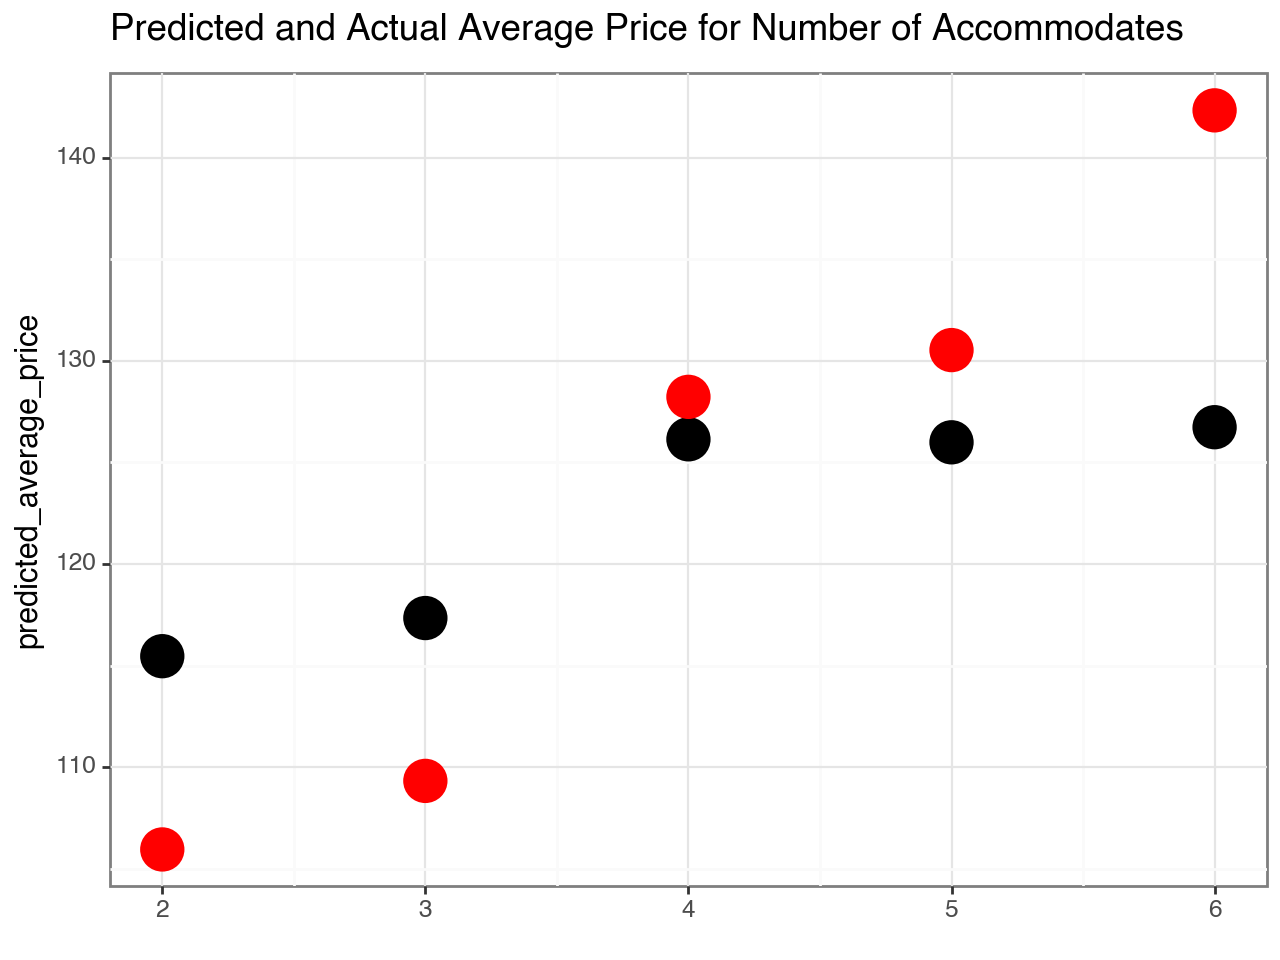

<Figure Size: (640 x 480)>

In [120]:
#partial depenedence plot showing number of accommodates by Random Forest's predicted average_price
#(keeping the other predictor variables constant)
p = (ggplot(pred_avg_price_by_accom, aes(x = range(2,7), y = 'predicted_average_price')) 
 + geom_point(size = 8) + theme_bw() + ggtitle('Predicted and Actual Average Price for Number of Accommodates')
    +geom_point(aes(x = range(2,7), y = 'actual_average_price'), size = 8, color = 'red'))
p

#Random Forest's predicted_average_price = black
#actual_average_price from the dataset = red

## Summary
Model 4/Random Forest proved to be the best model as it had the lowest cross-validated RMSE. Using Model 4, I predicted the average price of an apartment stay with 2-6 accommodates/guests on the Airbnb market in Austin, TX (USA). From the prediction, keeping all other predictor variables constant, I would recommend that the fictional business price their apartments anywhere from 115-126 USD/day, depending on the number of guests an apartment could accommodate.
I would also take into account the importance of each predictor variable. Seeing as how availability_365_x was the most important variable, the price should be adjusted accordingly based on the availability of the listing a year in advance. Number_of_reviews_x was the second highest rated variable. Because the company would be listing new apartments on the market, this variable may seem like it doesn't apply to the case at hand; however, it is important as the company could decide to reprice the apartment once it gets to a certain number of reviews (if placed on the Airbnb market. Also further research would have to be done to see what the minimum number of reviews would be in order for th